About the homework: In some tasks, in addition to writing code, answers to questions and conclusions are required (there are special Markdown cells marked with **Answer**).

The ability to analyze the results of experiments is an important skill. Therefore, answers carry more weight than the code: the code accounts for 30% of the task grade, while answers to questions account for 70%.

**Reminder:** Plagiarism is prohibited. Use of AI without mentioning how and in which parts it was used is also prohibited. If plagiarism or dishonest use of AI is revealed, the assignment is graded with 0.

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Let's work with Titanic dataset again: Download `train.csv` file from https://www.kaggle.com/c/titanic/data?select=train.csv

In [48]:
df = pd.read_csv('train.csv')
df.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
455,456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
203,204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C


# Task 1 (1 point)

Split dataFrame into train and test. Set `test_size=0.3, random_state=0`

In [49]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

Let's start preprocessing the features:



*   Drop features with $>40%$ missing values and `'PassengerId'`
*   Fill missing values with median (for numerical features) and mode (for categorical features)



In [50]:
missing_cnt = df.isnull().mean()
threshold = 0.4
features_to_drop = missing_cnt[missing_cnt > threshold].index.to_list()
features_to_drop.append('PassengerId')
df.drop(columns=features_to_drop, inplace=True)

numerical_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(exclude=[np.number]).columns

numeric_values = df[numerical_features].median()
categorical_values = df[categorical_features].mode()

df.fillna(numeric_values, inplace=True)
df.fillna(categorical_values, inplace=True)

df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

How many features do we have now? (Do not count `'Survived'` - this will be target)

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 857 to 684
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  623 non-null    int64  
 1   Pclass    623 non-null    int64  
 2   Name      623 non-null    object 
 3   Sex       623 non-null    object 
 4   Age       623 non-null    float64
 5   SibSp     623 non-null    int64  
 6   Parch     623 non-null    int64  
 7   Ticket    623 non-null    object 
 8   Fare      623 non-null    float64
 9   Embarked  621 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 53.5+ KB


Now we have 9 features

# Task 2 (2 points)

Now, let's use one-hot-encoding to encode columns with type `'object'`:



*   Fit the Encoder on train data
*   Apply to train and test
*   Check, how many new features we have now

Describe the problems you have faced (hint: one of the problems - `ValueError` and the solution will be to set `handle_unknown` in the `OneHotEncoder`). Explain, why did they occur, which impact may they have  on the training process?

In [52]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features)], 
    remainder='passthrough')
X_train = column_transformer.fit_transform(df_train).astype(np.float64)
X_test = column_transformer.transform(df_test).astype(np.float64)

In [53]:
print(df_train.shape)
print(X_train.shape)

(623, 10)
(623, 1145)


**Answer** 1145 features


Drop the columns `'Name','Ticket'` and try again.

In [54]:
y_train = df_train['Survived']
y_test = df_test['Survived']

df_train.drop(columns=['Name', 'Ticket', 'Survived'], inplace=True)
df_test.drop(columns=['Name', 'Ticket', 'Survived'], inplace=True)
categorical_features = categorical_features.drop(['Name', 'Ticket'])

column_transformer = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features)], 
    remainder='passthrough')
X_train = column_transformer.fit_transform(df_train).astype(np.float64)
X_test = column_transformer.transform(df_test).astype(np.float64)

In [55]:
print(df_train.shape)
print(X_train.shape)

(623, 7)
(623, 11)


Combine numerical features and encoded categorical and split the data into `X` (objects with features) and `y` (target - `Survived` column) for train and test data.

Done in previous cell

# Task 3 (2 points)

Which metric will be better suitable for our machine learning task? (We want to predict if passenger survived or not). Explain your choice.

**Answer** We have binary classification task here. For such tasks we have several metrics:
1) Accuracy - the simpliest one - the proportion of correctly predicted classes

2) Precision $$\frac{TP}{TP + FP}$$ - proportion of correctly predicted +1 class

3) Recall $$\frac{TP}{TP + FN}$$ - coverage of +1 class

4) F1-score - combination of Precision and Recall
$$\frac{2 * pr * rec}{pr + rec}$$

5) F-score in general - combination of Precision and Recall with parameter
$$(1 + \beta^2) \cdot \frac{pr * rec}{\beta ^ 2 \cdot pr + rec}$$

6) ROC_AUC and PR_AUC - areas under ROC (TPR/FPR) and PR (PR/REC) curves

In [56]:
print(df['Survived'].value_counts())
print(df['Survived'].sum() / df.shape[0])

Survived
0    549
1    342
Name: count, dtype: int64
0.3838383838383838


As we see, we have explicit imbalance of classes. Because of this, it's better to use metrics 4-6. I'll use F1-score

Fit logistic regression and evaluate the performance on train and test data (using metric you chose)

In [57]:
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, max_iter=1000)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1-Score on Train Data: {f1_train}")
print(f"F1-Score on Test Data: {f1_test}")

F1-Score on Train Data: 0.7304347826086957
F1-Score on Test Data: 0.7236180904522613


Now, use `GridSearchCV` to find better hyperparameters (to avoid warnings about total number of iterations, set `max_iter=1000`)

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

params = {'C' : np.logspace(-5, 3, 20)
}

clf_lr = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=3, scoring=make_scorer(f1_score))
clf_lr.fit(X_train, y_train)
best_params_lr = clf_lr.best_params_
best_model_lr = clf_lr.best_estimator_
print(f"Best Hyperparameters: {best_params_lr}")
y_train_pred = best_model_lr.predict(X_train)
y_test_pred = best_model_lr.predict(X_test)
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f"F1-Score on Train Data: {f1_train}")
print(f"F1-Score on Test Data: {f1_test}")

Best Hyperparameters: {'C': np.float64(0.4281332398719396)}
F1-Score on Train Data: 0.7324561403508771
F1-Score on Test Data: 0.7236180904522613


# Task 4 (2 points)

Fit a decision tree using `GridSearchCV`. Use the parameter grid for hyperparameters `max_depth, min_samples_split, min_samples_leaf`

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = { 'max_depth' : np.arange(2, 32, 3),
          'min_samples_split' : np.arange(2, 32, 3),
           'min_samples_leaf' : np.arange(2, 32, 3)
}

clf_tree = GridSearchCV(DecisionTreeClassifier(), params, cv=3, scoring=make_scorer(f1_score))
clf_tree.fit(X_train, y_train)
best_params_tree = clf_tree.best_params_
best_model_tree = clf_tree.best_estimator_
print(f"Best Hyperparameters: {best_params_tree}")
y_train_pred = best_model_tree.predict(X_train)
y_test_pred = best_model_tree.predict(X_test)
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f"F1-Score on Train Data: {f1_train}")
print(f"F1-Score on Test Data: {f1_test}")

Best Hyperparameters: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(17)}
F1-Score on Train Data: 0.7929515418502202
F1-Score on Test Data: 0.7551020408163265


Now, use soft voting strategy to combine logistic regression and decision tree (use the ones with the best hyperparameters). Measure the quality on train and test data. Did the quality improve?

In [60]:
from sklearn.ensemble import VotingClassifier

model1 = best_model_lr
model2 = best_model_tree

voting_clf = VotingClassifier(estimators=[
    ('lr', model1), 
    ('tree', model2)
], voting='soft')

voting_clf.fit(X_train, y_train)
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f"F1-Score on Train Data: {f1_train}")
print(f"F1-Score on Test Data: {f1_test}")

F1-Score on Train Data: 0.793859649122807
F1-Score on Test Data: 0.7357512953367875


**Answer** As wee see, quality is almost the same with decision tree (even less)


# Task 5 (2 points)

Now, let's work with random forest and conduct similar experiment to the one on the seminar: let's fit `RandomForestClassifier` for different number of trees and check, how  the quality changes. Draw conclusions.

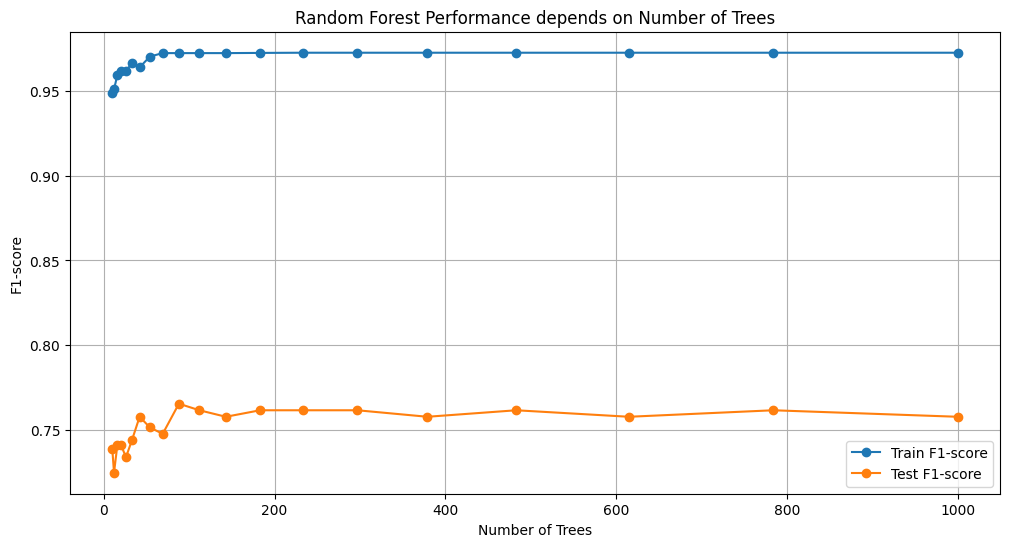

In [61]:
from sklearn.ensemble import RandomForestClassifier

params = list(map(np.int64, np.logspace(1, 3, 20)))

train_f1_scores = []
test_f1_scores = []

for n_trees in params:
    rf_clf = RandomForestClassifier(n_estimators=n_trees, random_state=0)
    rf_clf.fit(X_train, y_train)
    
    y_train_pred = rf_clf.predict(X_train)
    y_test_pred = rf_clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

plt.figure(figsize=(12, 6))
plt.plot(params, train_f1_scores, label='Train F1-score', marker='o')
plt.plot(params, test_f1_scores, label='Test F1-score', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('F1-score')
plt.title('Random Forest Performance depends on Number of Trees')
plt.legend()
plt.grid()
plt.show()

With how many trees the best train quality is achived? What the test quality will be?

In [62]:
id = train_f1_scores.index(max(train_f1_scores))
print(f"Number of trees: {params[id]}")
print(f"Train f1-score max: {train_f1_scores[id]}")
print(f"Test f1-score: {test_f1_scores[id]}")

id = test_f1_scores.index(max(test_f1_scores))
print(f"Number of trees: {params[id]}")
print(f"Train f1-score max: {train_f1_scores[id]}")
print(f"Test f1-score: {test_f1_scores[id]}")

Number of trees: 233
Train f1-score max: 0.9728601252609603
Test f1-score: 0.7614213197969543
Number of trees: 88
Train f1-score max: 0.9726315789473684
Test f1-score: 0.7653061224489796


And the same experiment using `AdaBoost` (set `algorithm='SAMME'` as hyperparameter to avoid warnings), draw conclusions

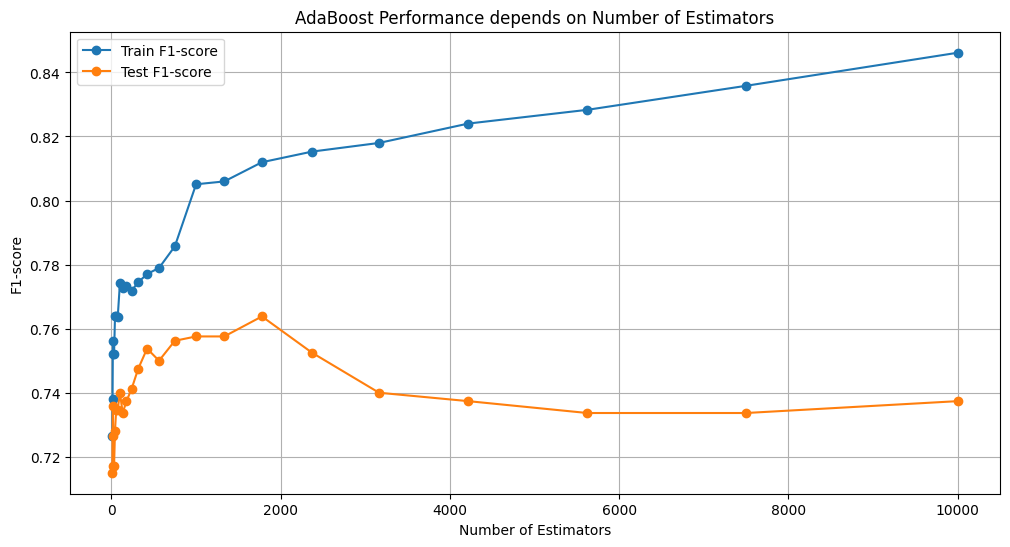

In [63]:
from sklearn.ensemble import AdaBoostClassifier

params = list(map(np.int64, np.logspace(1, 4, 25)))

train_f1_scores = []
test_f1_scores = []

for n_estimators in params:
    ada_clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
    ada_clf.fit(X_train, y_train)
    
    y_train_pred = ada_clf.predict(X_train)
    y_test_pred = ada_clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

plt.figure(figsize=(12, 6))

plt.plot(params, train_f1_scores, label='Train F1-score', marker='o')
plt.plot(params, test_f1_scores, label='Test F1-score', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('F1-score')
plt.title('AdaBoost Performance depends on Number of Estimators')
plt.legend()
plt.grid()
plt.show()

With how many models the best train quality is achived? What the test quality will be?

In [64]:
id = train_f1_scores.index(max(train_f1_scores))
print(f"Number of models: {params[id]}")
print(f"Train f1-score max: {train_f1_scores[id]}")
print(f"Test f1-score: {test_f1_scores[id]}")

id = test_f1_scores.index(max(test_f1_scores))
print(f"Number of models: {params[id]}")
print(f"Train f1-score max: {train_f1_scores[id]}")
print(f"Test f1-score: {test_f1_scores[id]}")

Number of models: 10000
Train f1-score max: 0.8461538461538461
Test f1-score: 0.7373737373737373
Number of models: 1778
Train f1-score max: 0.811965811965812
Test f1-score: 0.7638190954773869


**Answer** Here we can notice that in Random Forest case, if we take "best train score" model and "best test score" model, they have 233 and 88 trees respectively. And scores are very close (almost the same).
But, in AdaBoost case, number of models are 10000 and 1778. And scores differ a lot. Also you can see this situation on graph above.
And train scores are much less than with Random Forest. It means that AdaBoost doesn't have the ability to retrain on training data. Scores will be close in any data we'll give to AdaBoost

# Task 6 (1 point)

What is the best quality achived? Which model did achive it? Whith which hyperparameters? Does it seem logical?

**Answer**
1) Best train score: 0.9728601252609603, RandomForestClassifier with 233 trees
2) Best test score: 0.7653061224489796, RandomForestClassifier with 88 trees
As we see, the best model for our task is RandomForestClassifier. But also good test score got by AdaBoost. And great ability of such model - to get close scores on train and test data (stability)